# India Flood prediction

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt

## Load disaster dataset

In [51]:
datasets_path = './datasets/disasters/Flood_clean.csv'
disaster_df = pd.read_csv(datasets_path)

disaster_df = disaster_df.rename(columns=lambda x: x.strip().lower())
valuable_cols = ['description', 'alertscore', 'country', 'fromdate', 'todate', 'severity (magnitude)', 'death', 'displaced', 'longitude', 'latitude']
disaster_df = disaster_df[valuable_cols]

disaster_df['fromdate'] = pd.to_datetime(disaster_df['fromdate'])
disaster_df['todate'] = pd.to_datetime(disaster_df['todate'])

disaster_df = disaster_df[disaster_df['country'].str.contains('India')]
disaster_df = disaster_df[disaster_df['fromdate'] <= '2021-12-31']

print(disaster_df.size/len(disaster_df.columns))

101.0


approximate event to the closest weather station

In [52]:
stations = {
    'Bangalore': (26.3, 73.0167),
    'Chennai': (13.0667, 80.25),
    'Delhi': (28.5833, 77.2),
    'Lucknow': (26.8667, 80.933),
    'Mumbai': (19.1167, 72.85),
    'Rajasthan': (12.9667, 77.5833),
    'Bhubhneshwar': (20.25, 85.8333),
    'Rourkela': (22.2167, 84.8833),
}

def closest_station(lat, lon):
    closest = None
    closest_dist = float('inf')
    for station, (stat_lat, stat_lon) in stations.items():
        dist = (lat - stat_lat)**2 + (lon - stat_lon)**2
        if dist < closest_dist:
            closest = station
            closest_dist = dist
    return closest, closest_dist

for index, row in disaster_df.iterrows():
    station, dist = closest_station(row['latitude'], row['longitude'])
    disaster_df.at[index, 'closest_station'] = station
    disaster_df.at[index, 'station_distance'] = dist

disaster_df.head()

,description,alertscore,country,fromdate,todate,severity (magnitude),death,displaced,longitude,latitude,closest_station,station_distance
30,GREEN Flood in Eastern India from: 10 Jun 2000...,1.0,Eastern India,2000-06-10,2000-06-10 00:00:00,5.89,30.0,50000.0,94.798,27.426,Rourkela,125.438083
35,ORANGE Flood in India from: 31 Jul 2000 00 to:...,2.0,India,2000-07-31,2000-08-04 23:59:59,4.79,140.0,4000.0,77.692,31.806,Delhi,10.627859
36,ORANGE Flood in Western India from: 17 Jul 200...,2.0,Western India,2000-07-17,2000-07-17 00:00:00,6.18,140.0,-1.0,74.520,15.811,Mumbai,13.716552
38,ORANGE Flood in India from: 29 Aug 2000 00 to:...,2.0,India,2000-08-29,2000-09-14 23:59:59,6.58,578.0,-1.0,80.468,26.961,Lucknow,0.225117
42,GREEN Flood in India from: 30 Aug 2000 00 to: ...,1.0,India,2000-08-30,2000-09-01 23:59:59,5.04,40.0,5000.0,80.038,19.934,Rourkela,28.687651


## Load weather dataset

In [35]:
stations = [
    'Bangalore',
    'Chennai',
    'Delhi',
    'Lucknow',
    'Mumbai',
    'Rajasthan',
    'Bhubhneshwar',
    'Rourkela',
]
weather_df = pd.DataFrame()

for file in os.listdir('./datasets/weather_india/'):
    if file.endswith('.csv'):
        station_name = None
        for s in stations:
            if s in file:
                station_name = s
                print(f"Loading data for station: {station_name} from file: {file}")
        if station_name is None:
            raise ValueError(f"Station name not found in file {file}")
        
        tmp = pd.read_csv(os.path.join('./datasets/weather_india/', file))
        tmp['station'] = station_name
        tmp['time'] = pd.to_datetime(tmp['time'], errors='coerce')
        tmp = tmp[tmp['time'].between('2000-01-01', '2021-12-31')]
        weather_df = pd.concat([weather_df, tmp], ignore_index=True) 

weather_df.head()

Loading data for station: Bangalore from file: Bangalore_1990_2022_BangaloreCity.csv
Loading data for station: Chennai from file: Chennai_1990_2022_Madras.csv
Loading data for station: Delhi from file: Delhi_NCR_1990_2022_Safdarjung.csv
Loading data for station: Lucknow from file: Lucknow_1990_2022.csv
Loading data for station: Mumbai from file: Mumbai_1990_2022_Santacruz.csv
Loading data for station: Rajasthan from file: Rajasthan_1990_2022_Jodhpur.csv
Loading data for station: Bhubhneshwar from file: weather_Bhubhneshwar_1990_2022.csv
Loading data for station: Rourkela from file: weather_Rourkela_2021_2022.csv
Loading data for station: Bhubhneshwar from file: weather_Bhubhneshwar_1990_2022.csv
Loading data for station: Rourkela from file: weather_Rourkela_2021_2022.csv


,time,tavg,tmin,tmax,prcp,station,snow,wdir,wspd,wpgt,pres,tsun
0,2000-01-01,19.2,NaN,26.1,0.0,Bangalore,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-02-01,19.4,14.8,NaN,NaN,Bangalore,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-03-01,20.4,NaN,25.8,0.0,Bangalore,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-04-01,20.7,15.8,NaN,0.0,Bangalore,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-05-01,20.9,16.2,27.8,0.0,Bangalore,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
weather_df.isna().sum()

time           0
tavg          32
tmin        4114
tmax        1857
prcp       15144
station        0
snow       27223
wdir       25996
wspd       25161
wpgt       27223
pres       26048
tsun       27223
dtype: int64

In [37]:
weather_df['station'].value_counts()

station
Bhubhneshwar    8036
Bangalore       3168
Delhi           3168
Chennai         3168
Lucknow         3168
Mumbai          3168
Rajasthan       3168
Rourkela         179
Name: count, dtype: int64

In [38]:
print(weather_df.size/len(weather_df.columns))

27223.0


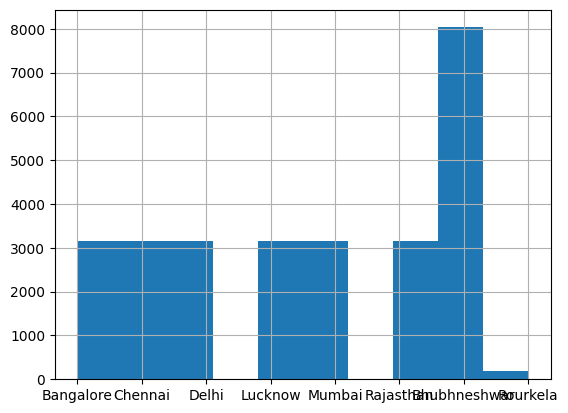

In [39]:
weather_df['station'].hist()
plt.show()

## Combining the datasets

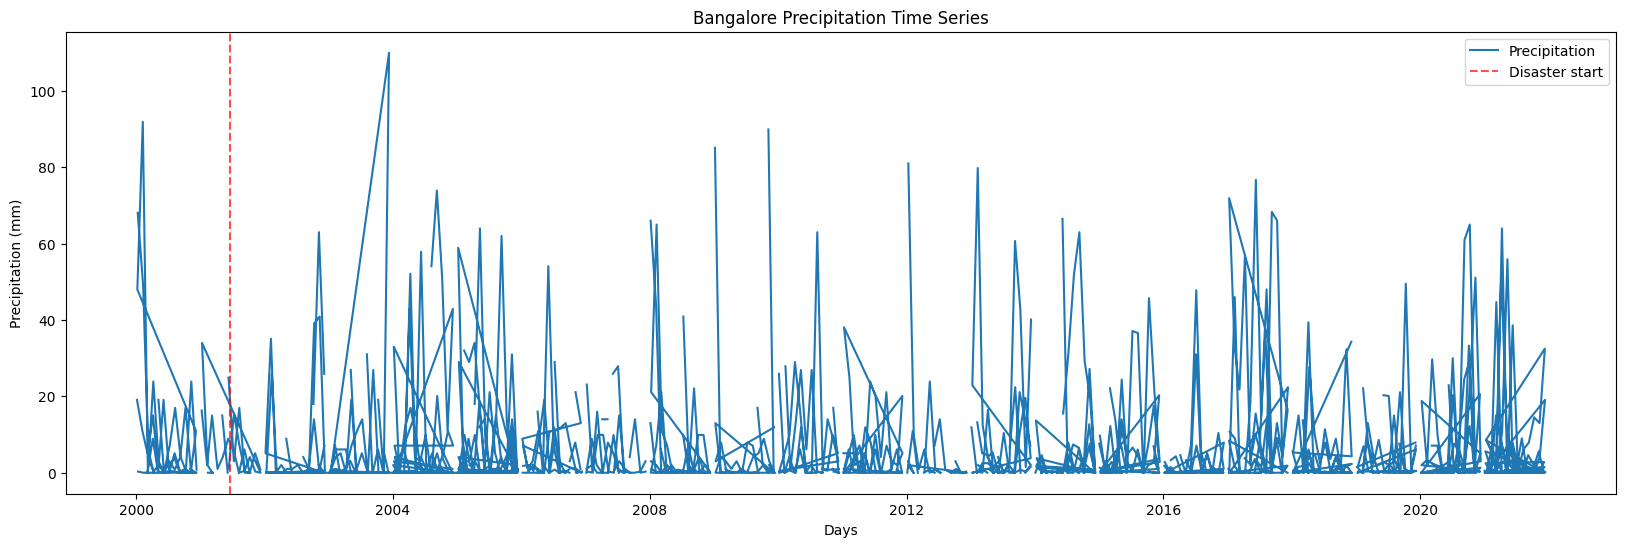

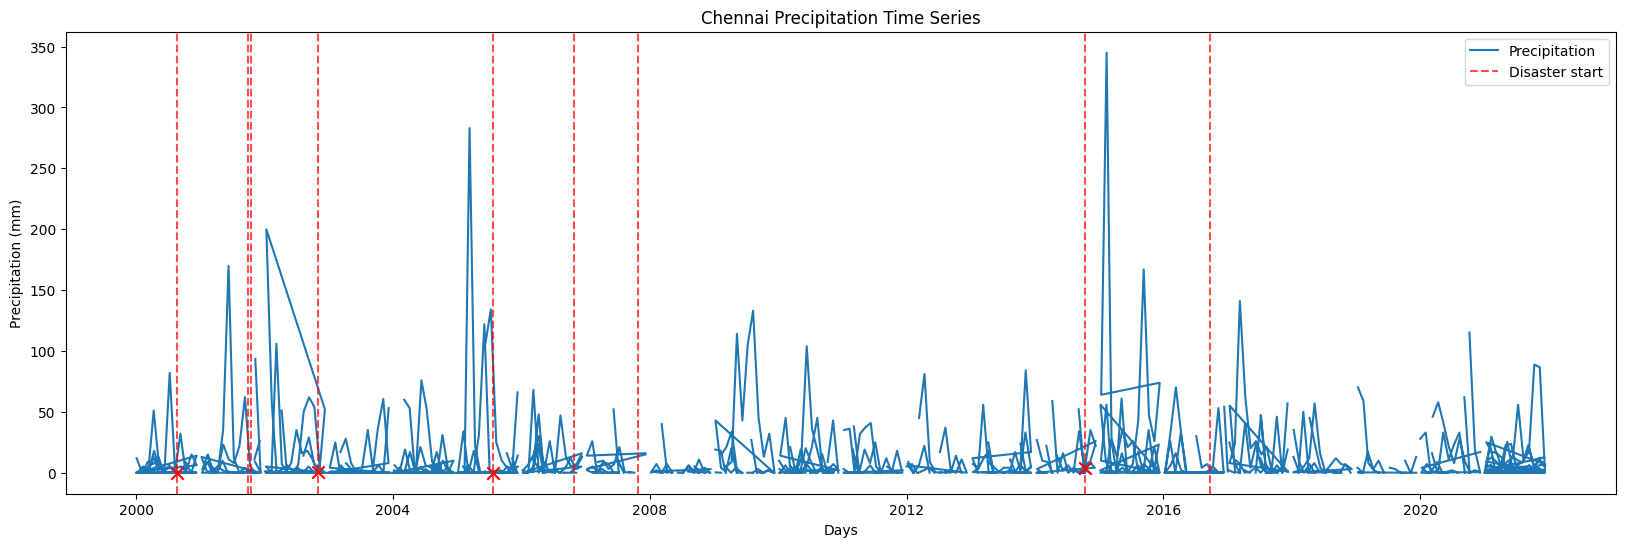

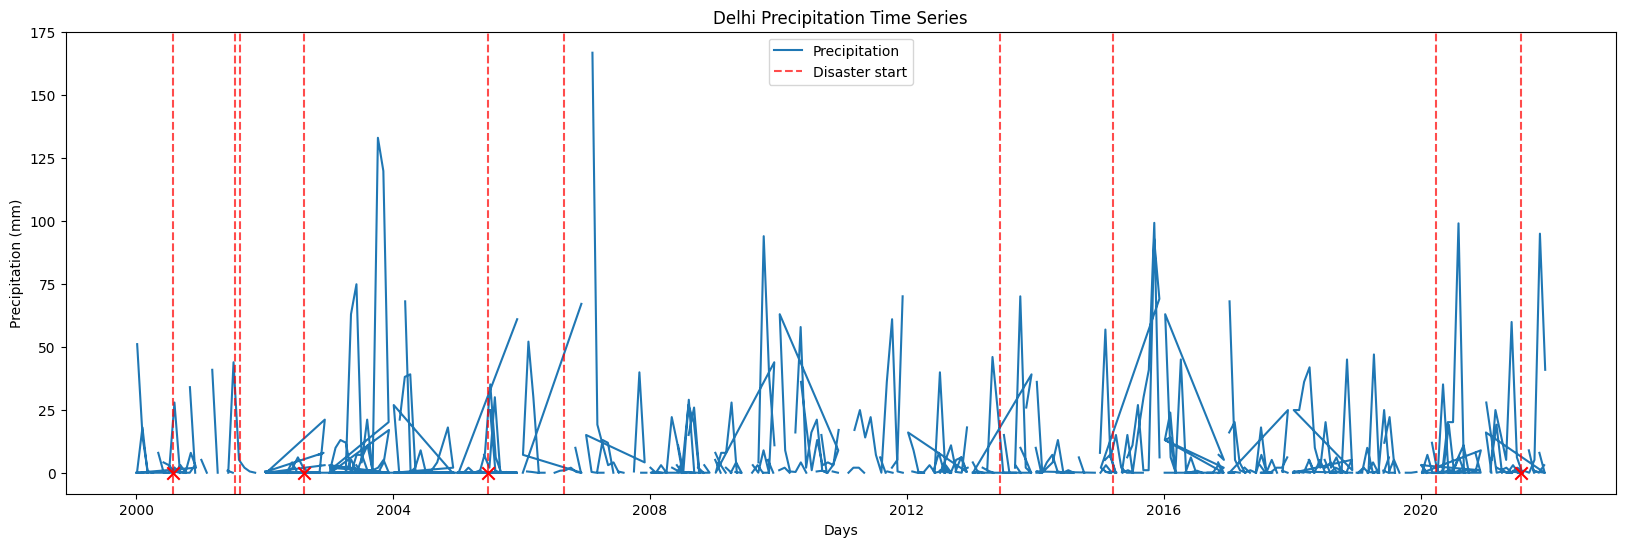

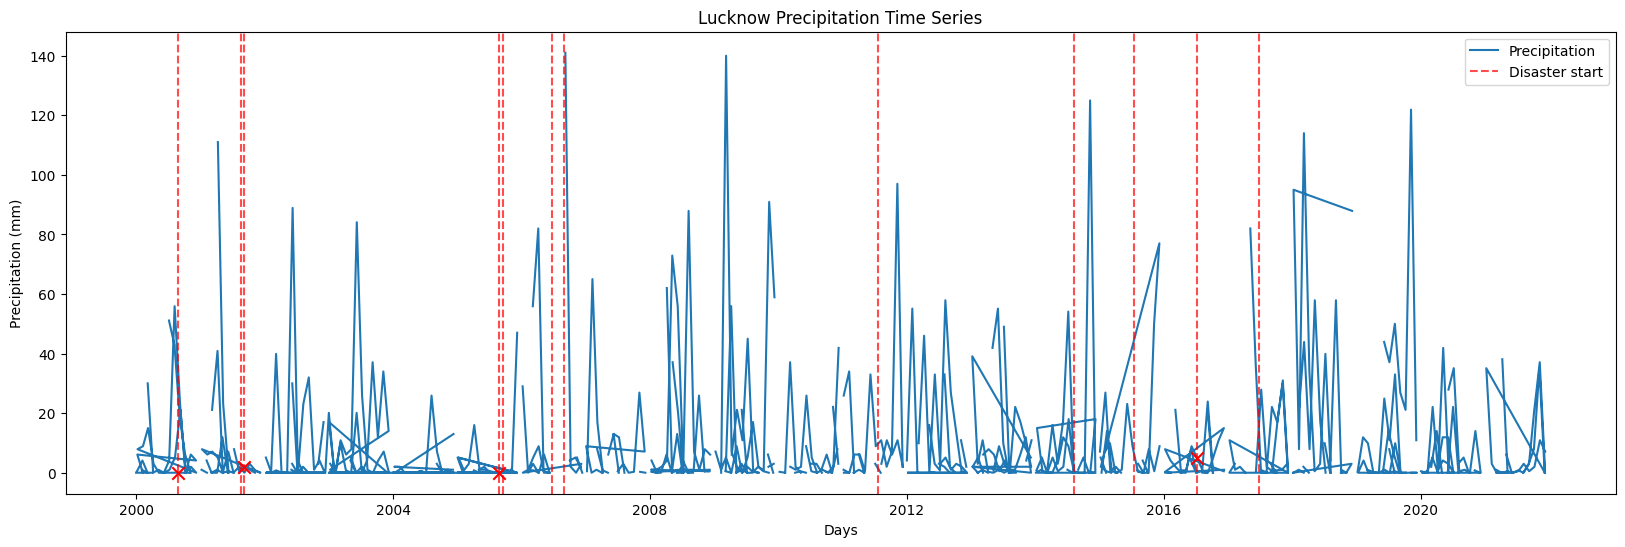

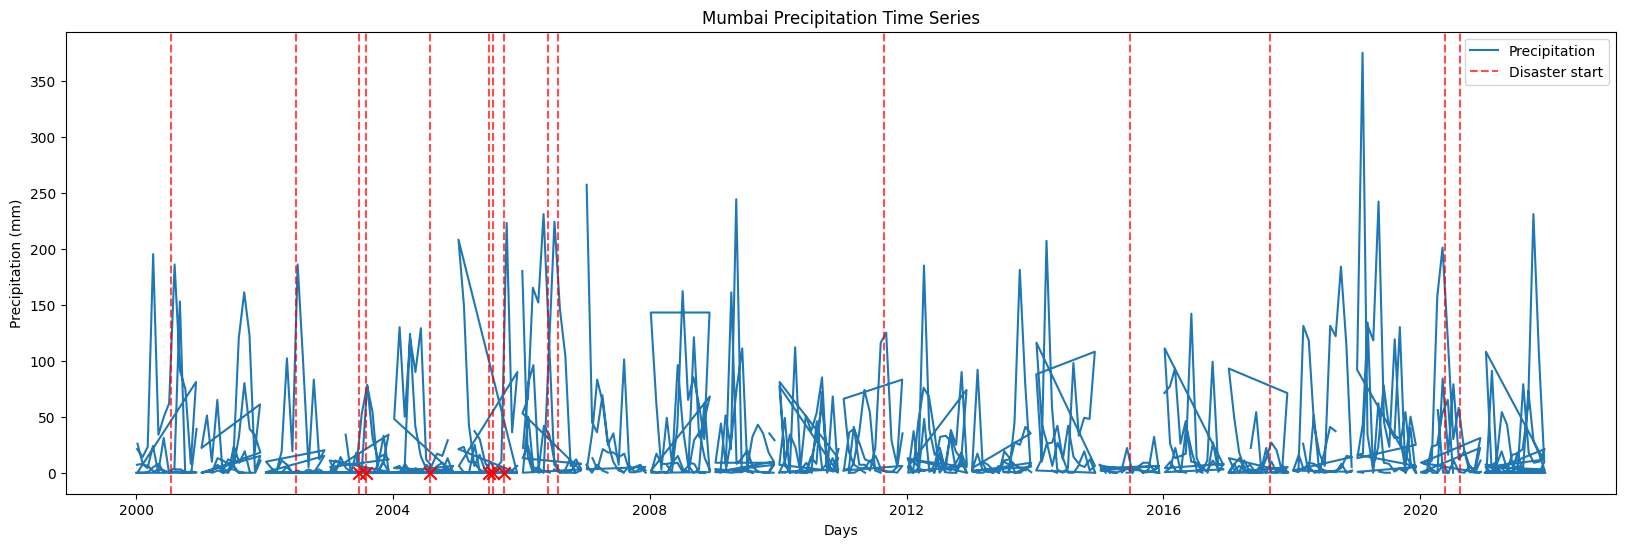

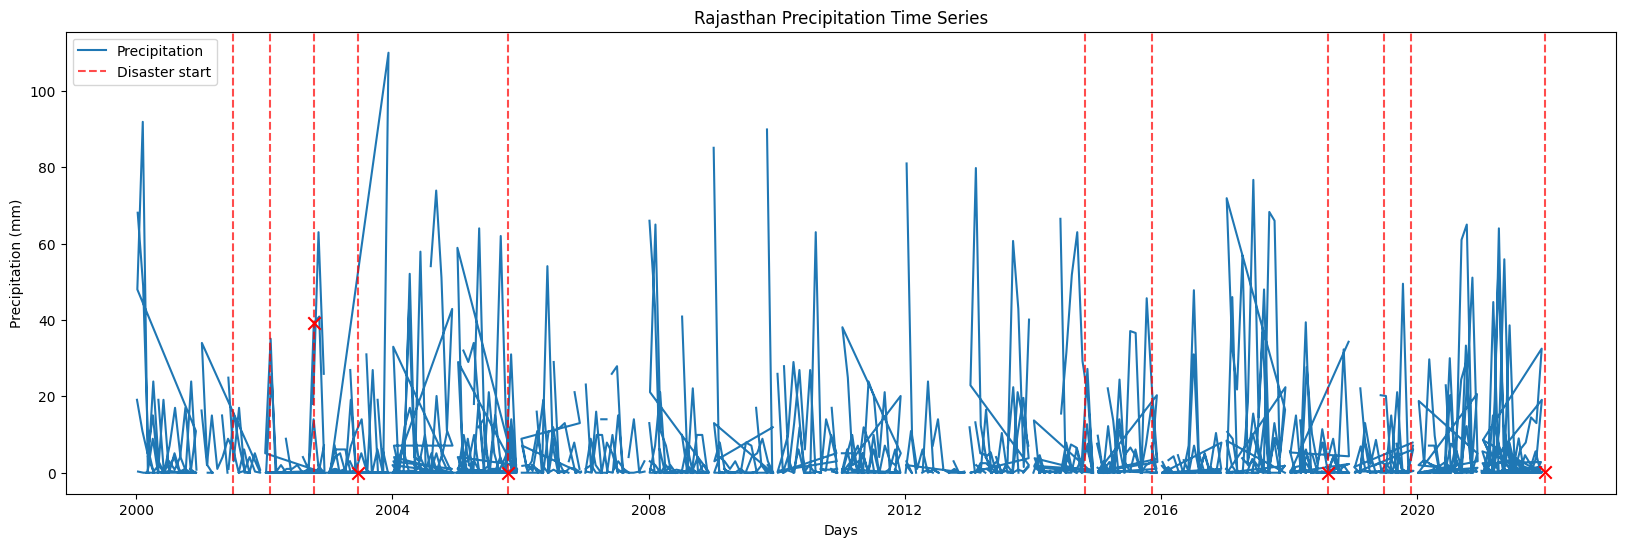

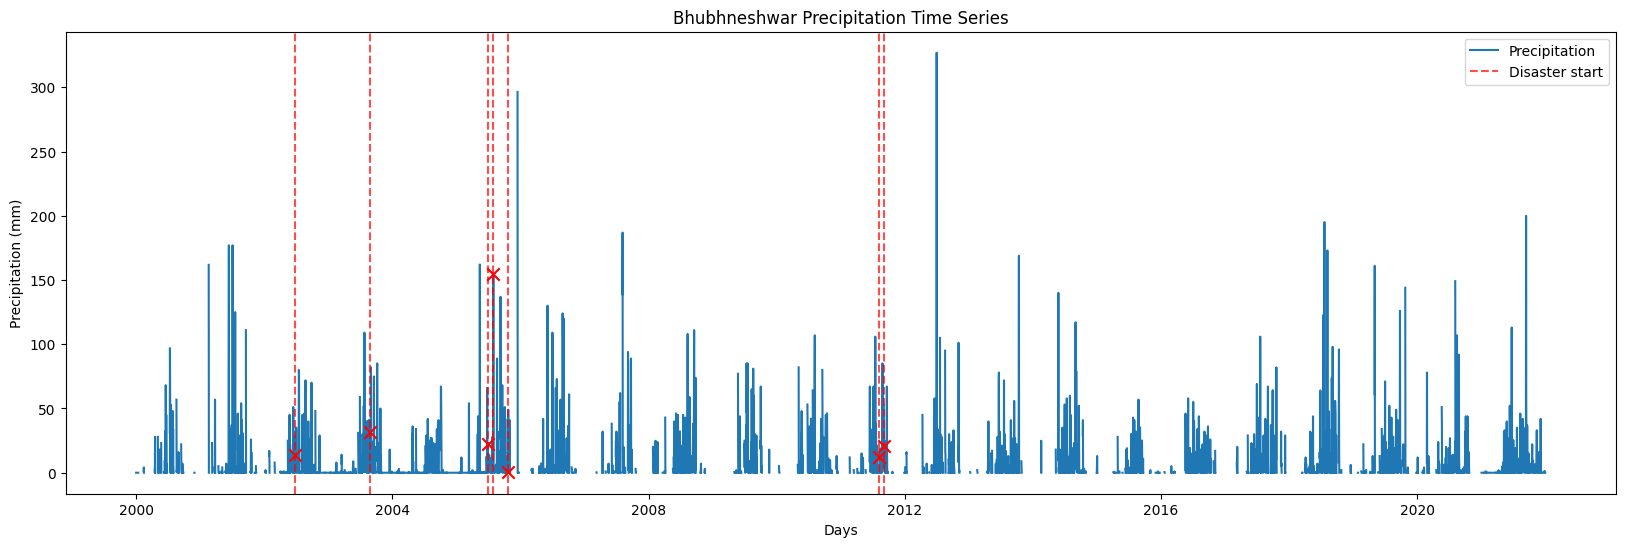

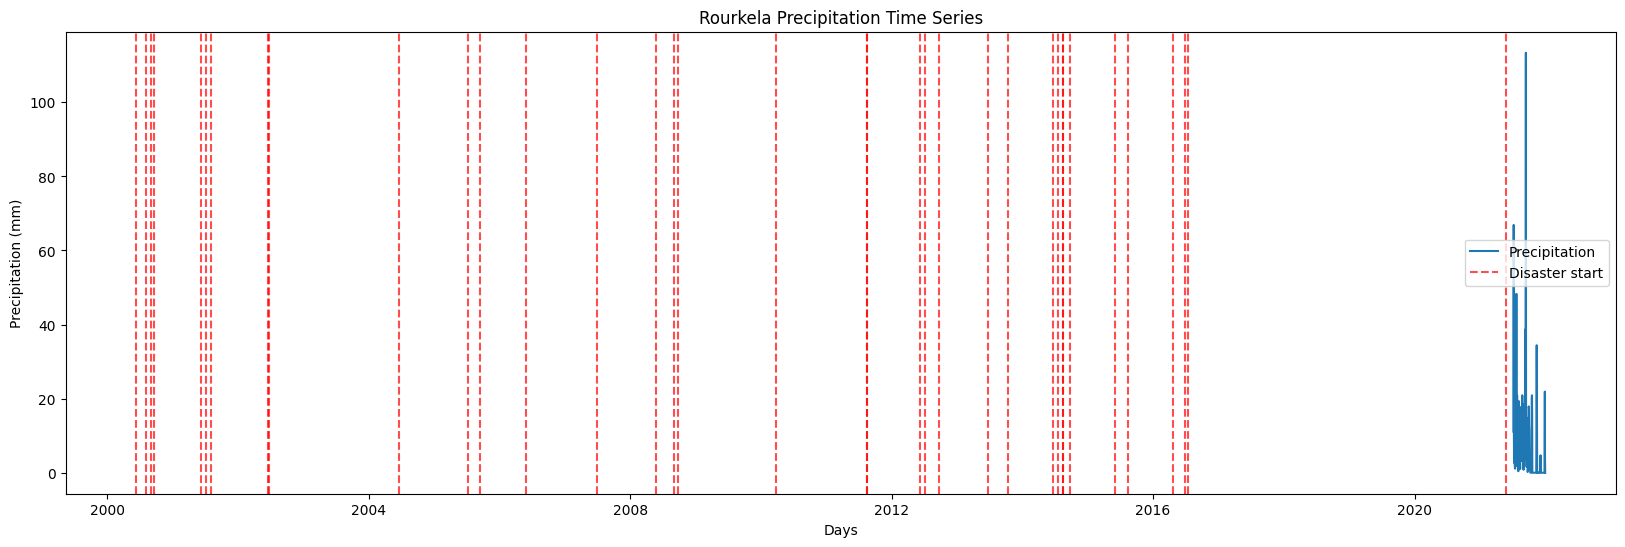

In [73]:
for city in stations:
    # creating experiment for every city
    city_disasters = disaster_df[disaster_df['closest_station'] == city]
    city_weather = weather_df[weather_df['station'] == city]

    # plot time series of precipitation with disaster markers
    plt.figure(figsize=(20, 6))
    plt.plot(city_weather['time'], city_weather['prcp'], label='Precipitation')

    # mark disaster start dates from bubhneshwar_disasters (if present)
    for d in pd.to_datetime(city_disasters['fromdate']):
        # vertical dashed line at disaster start
        plt.axvline(d, color='red', linestyle='--', alpha=0.7)
        # place an 'x' marker at the nearest precipitation observation to the disaster date
        if not city_weather.empty:
            nearest_idx = (city_weather['time'] - d).abs().idxmin()
            prcp_val = city_weather.loc[nearest_idx, 'prcp']
            plt.scatter(d, prcp_val, color='red', marker='x', s=80, zorder=5)
    # improve legend to include the disaster marker
    plt.legend(['Precipitation', 'Disaster start'])

    plt.xlabel('Days')
    plt.ylabel('Precipitation (mm)')
    plt.title(f'{city} Precipitation Time Series')
    plt.show()